### Dispersion de veloc para estrellas a z=0 en bines de edad
#### Esta tomado dentro de un anillo alrededor de r50 +/- 1kpc y cortado en +/- 5kpc de z

subhalo_127000000000002
10.748496


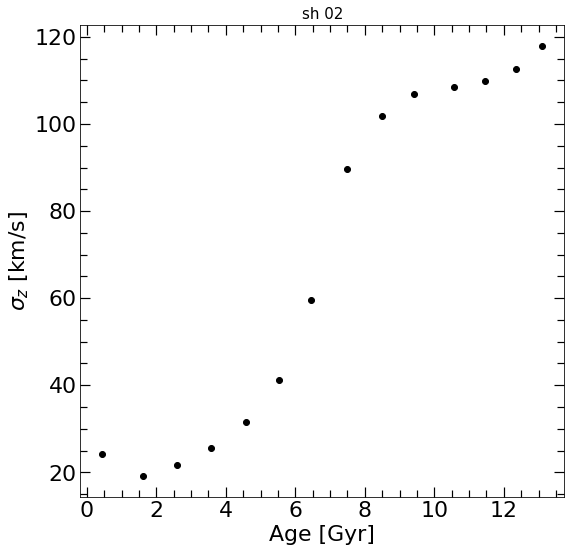

subhalo_127000000000003
13.477973


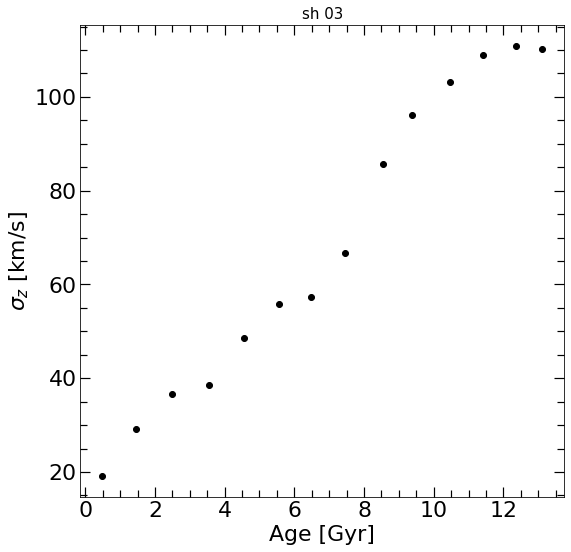

subhalo_127000000000004
9.724034


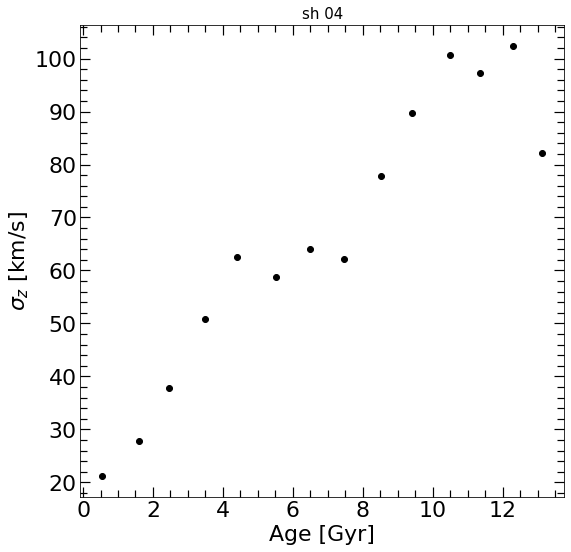

subhalo_127000000000006
5.276335


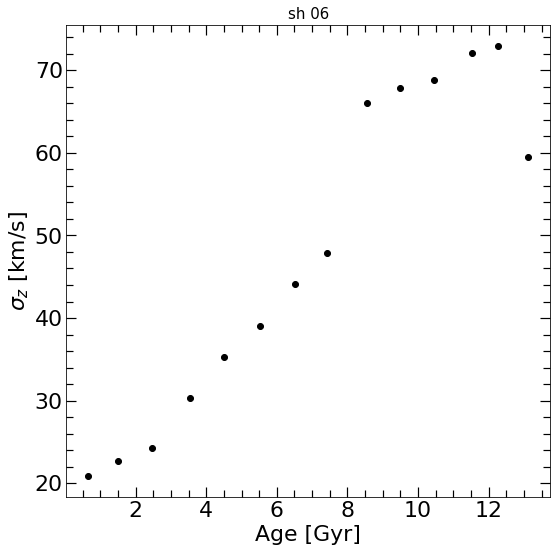

subhalo_127000000000007
4.6233883


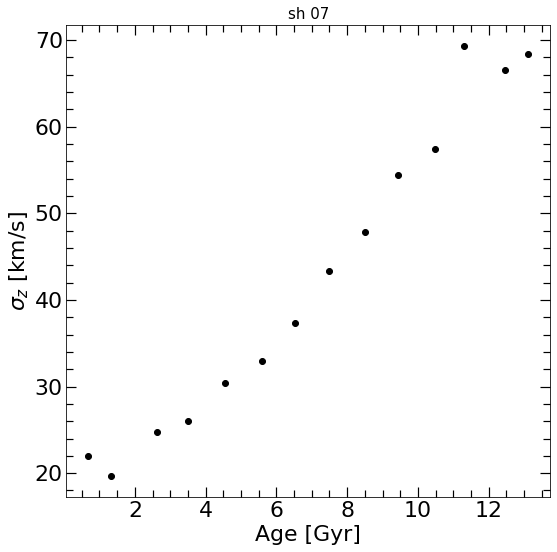

subhalo_127000000000009
5.1774135


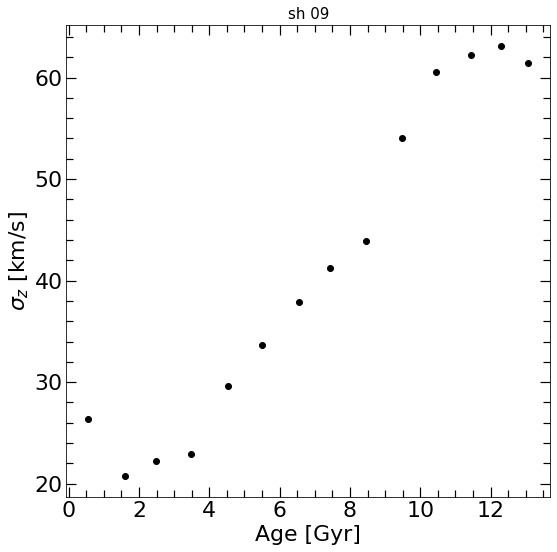

subhalo_127000000000012
5.7153077


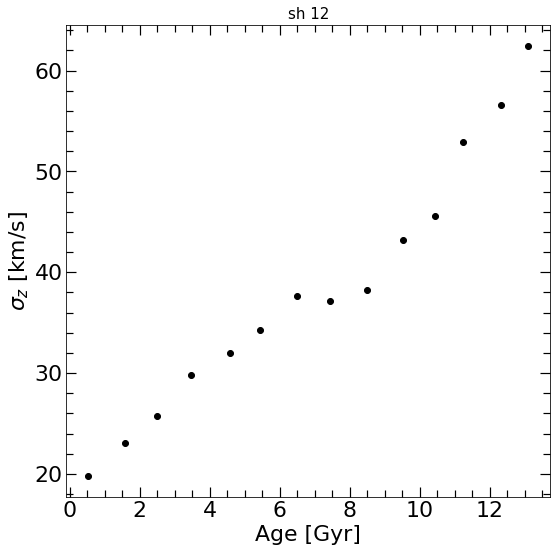

subhalo_127000000000011
5.450668


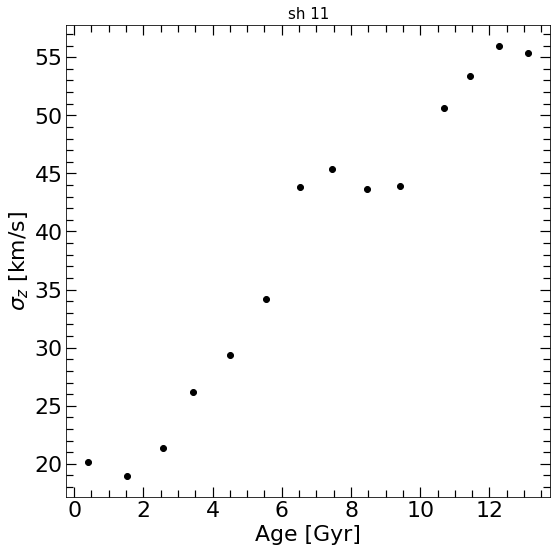

subhalo_127000000000014
6.0566792


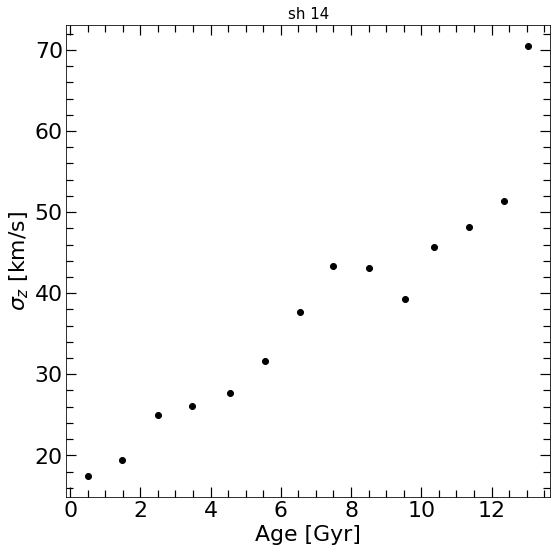

subhalo_127000000000020
3.773638


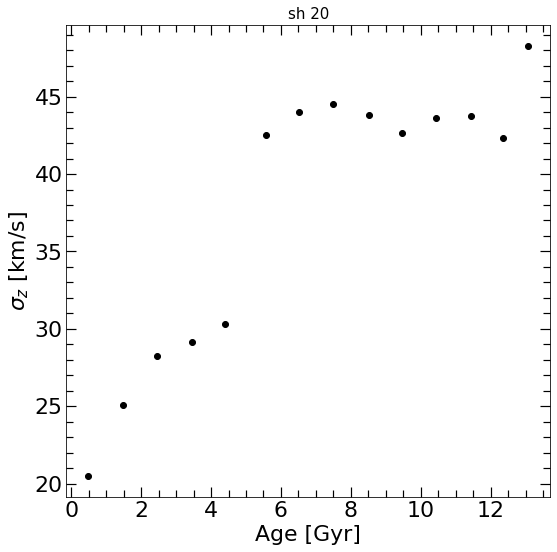

subhalo_127000000000021
5.069559


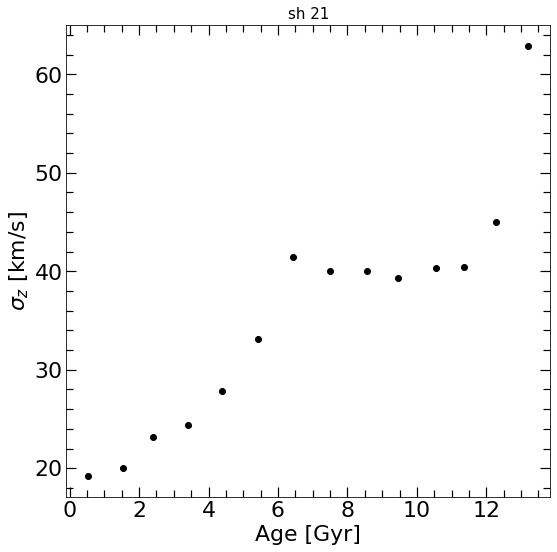

subhalo_127000000000023
4.417653


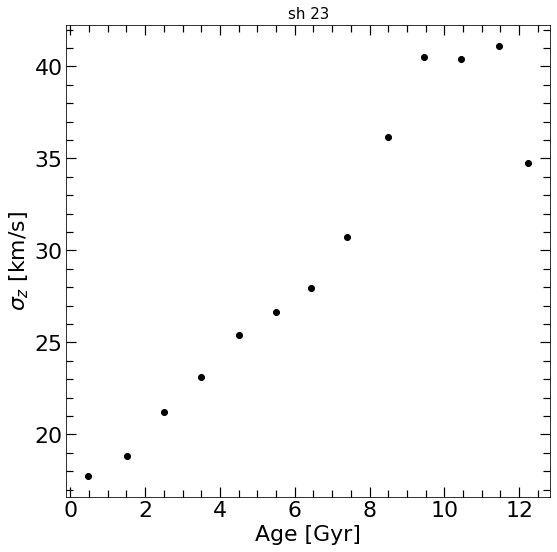

subhalo_127000000000028
1.8141063


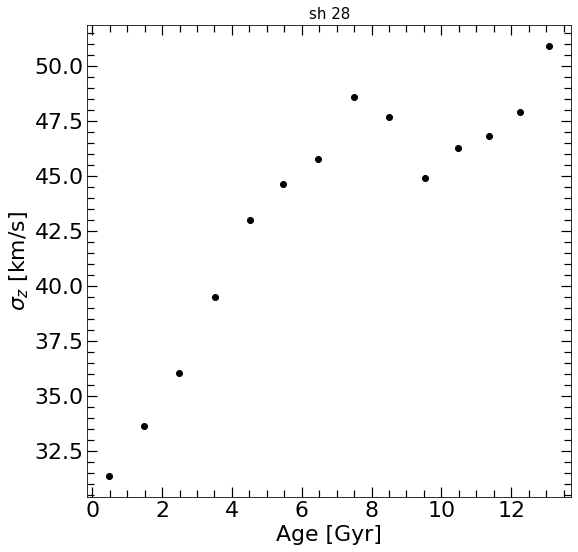

subhalo_127000000000031
1.5487609


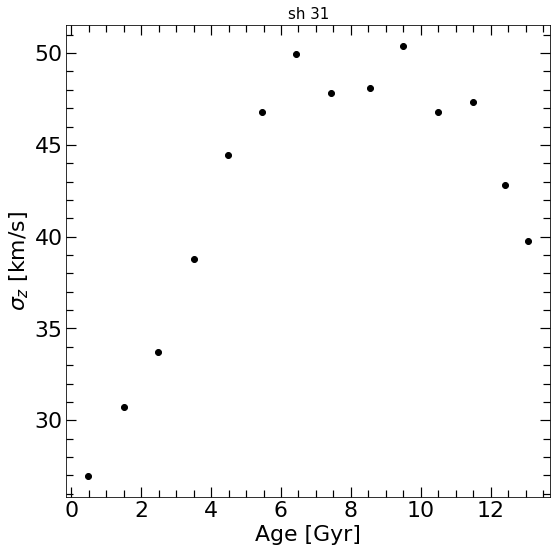

In [ ]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import z50 as z50_prof
import velocity_dispersion as vd

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for i in range(14):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Rvir = snap['/R200'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    # met  = snap['/Str/Total_Metallicity'][()]
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    # Ztot = met[amask]/0.0127 #para pasarlo a metalicidad solar (ver Illustris data)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]
    
    # if j == 127:
    r50_z0 = r50
    print(r50_z0)
    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    Rn_str = np.sqrt(xn_str**2 + yn_str**2)

    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
        
    gal, = np.where((Rn_str < r50_z0+1) & (Rn_str > r50_z0-1) & 
                    (zn_str < 5) & (zn_str > -5))
    
    age_bin = np.linspace(0,14,15)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), sharex=True)
    fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.96, top = 0.92,hspace=0.02)
    
    for i in range(len(age_bin)-1):
        age_lim, = np.where((age[gal]>age_bin[i]) & (age[gal]<age_bin[i+1]))
        
        if len(age_lim)<2:
            continue
        
        sigma_z = vd.vel_disp(vzn[gal][age_lim])
        
        ax.plot(np.median(age[gal][age_lim]),sigma_z,'ko')
    
    ax.minorticks_on()
    ax.tick_params( labelsize=22)
    ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right='on',top='on')
    ax.set_ylabel('$\sigma_z$ [km/s]',fontsize=22)
    ax.set_xlabel('Age [Gyr]',fontsize=22)
    ax.set_title('sh '+Id,fontsize=15)

    plt.show()

    fig.savefig('../_imagenes/veloc_disp/vd_age_s'+str('%d'%ID[i])+'.png',dpi=75, xxbox_inches='tight')